In [ ]:
%cd drive/MyDrive/projects/toxicity-multiclass
!ls


[Errno 2] No such file or directory: 'drive/MyDrive/projects/toxicity-multiclass'
/content/drive/MyDrive/projects/toxicity-multiclass
app.py	models	   pyproject.toml  results  src
data	notebooks  README.md	   scripts


In [ ]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

figures_dir = results_dir / "figures"
figures_dir.mkdir(exist_ok=True)

RESULT_FILES = {
    "XGBoost": "results/xgboost_results.json",
    "MLP": "results/mlp_results.json",
    "ChemBERTa": "results/chemberta_results.json",
}

results = {}
for model_name, path in RESULT_FILES.items():
    with open(path) as f:
        results[model_name] = json.load(f)

results.keys()


dict_keys(['XGBoost', 'MLP', 'ChemBERTa'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
rows = []
for model, res in results.items():
    rows.append({
        "model": model,
        "macro_f1_test": res["test"]["macro_f1"],
        "macro_roc_auc_test": res["test"]["macro_roc_auc"],
    })

df_summary = pd.DataFrame(rows).sort_values("macro_f1_test", ascending=False)
df_summary

df_summary.to_csv(results_dir / "model_comparison_summary.csv", index=False)
df_summary.to_json(
    results_dir / "model_comparison_summary.json",
    orient="records",
    indent=2
)


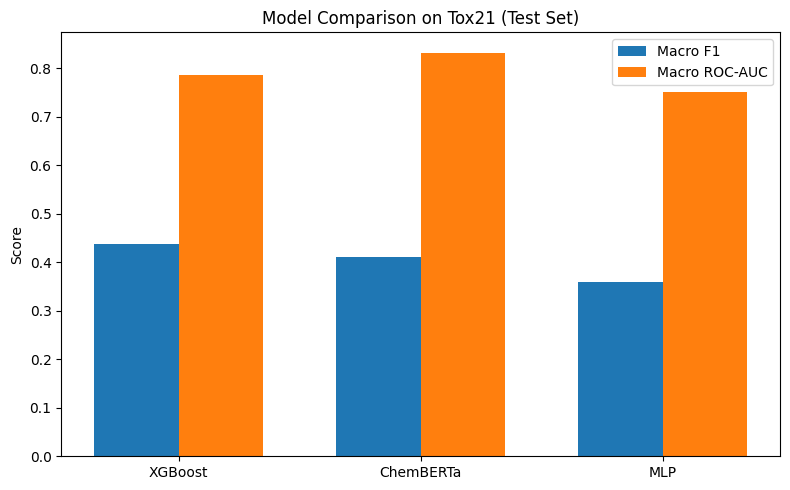

In [ ]:
x = np.arange(len(df_summary))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, df_summary["macro_f1_test"], width, label="Macro F1")
plt.bar(x + width/2, df_summary["macro_roc_auc_test"], width, label="Macro ROC-AUC")

plt.xticks(x, df_summary["model"])
plt.ylabel("Score")
plt.title("Model Comparison on Tox21 (Test Set)")
plt.legend()
plt.tight_layout()

plt.savefig(figures_dir / "model_comparison_test_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
tasks = list(next(iter(results.values()))["test"]["per_task"].keys())

rows = []
for task in tasks:
    row = {"task": task}
    for model, res in results.items():
        row[model] = res["test"]["per_task"].get(task, {}).get("f1", None)
    rows.append(row)

df_per_task = pd.DataFrame(rows)
df_per_task

df_per_task.to_csv(results_dir / "per_task_f1_comparison.csv", index=False)
df_per_task.to_json(
    results_dir / "per_task_f1_comparison.json",
    orient="records",
    indent=2
)


In [ ]:
df_winners = df_per_task.copy()
df_winners["best_model"] = df_winners[["XGBoost", "MLP", "ChemBERTa"]].idxmax(axis=1)

df_winners[["task", "best_model"]]

df_winner_counts = df_winners["best_model"].value_counts()
df_winner_counts

df_winners.to_csv(results_dir / "per_task_best_model.csv", index=False)
df_winners.to_json(
    results_dir / "per_task_best_model.json",
    orient="records",
    indent=2
)

df_winner_counts.to_csv(results_dir / "best_model_counts.csv")
df_winner_counts.to_json(results_dir / "best_model_counts.json", indent=2)

In [ ]:
df_winners = df_per_task.copy()
df_winners["best_model"] = df_winners[
    ["XGBoost", "MLP", "ChemBERTa"]
].idxmax(axis=1)

df_winners[["task", "best_model"]]


,task,best_model
0,NR-AR,MLP
1,NR-AR-LBD,XGBoost
2,NR-AhR,ChemBERTa
3,NR-Aromatase,XGBoost
4,NR-ER,ChemBERTa
5,NR-ER-LBD,XGBoost
6,NR-PPAR-gamma,XGBoost
7,SR-ARE,ChemBERTa
8,SR-ATAD5,XGBoost
9,SR-HSE,ChemBERTa


In [ ]:
df_winners["best_model"].value_counts()


,count
best_model,
ChemBERTa,6
XGBoost,5
MLP,1


In [ ]:
df_stats = pd.DataFrame({
    model: [
        res["test"]["macro_f1"],
        res["test"]["macro_roc_auc"],
    ]
    for model, res in results.items()
}, index=["Macro F1", "Macro ROC-AUC"])

df_stats


,XGBoost,MLP,ChemBERTa
Macro F1,0.437120,0.35959,0.410934
Macro ROC-AUC,0.785202,0.75050,0.831961
